### Agent state and action definition
* State Variable: x = [w, n, M, g_lag, e, s, A, (H, r, m), O_lag], actions variable a = [c, b, k, i, q] both of them are numpy array. n is the realized 401k balance before payment and contribution but after the realization of stock market. 

In [1]:
%pylab inline
from scipy.interpolate import interpn
from sklearn.neighbors import KNeighborsRegressor as KN
from helpFunctions import surfacePlot
import numpy as np
from scipy import optimize
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)


# time line
T_min = 0
T_max = 70
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# utility function parameter 
gamma = 2
# relative importance of housing consumption and non durable consumption 
alpha = 0.8
# parameter used to calculate the housing consumption 
kappa = 0.3
# depreciation parameter 
delta = 0.05
# housing parameter 
chi = 0.3
# uB associated parameter
B = 2
# minimum consumption 
c_bar = 3
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
r_b = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
# r_k = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_k = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1

# constant state variables: Purchase value 250k, down payment 50k, mortgage 200k, interest rate 3.6%,
# 55 payment period, 8.4k per period. One housing unit is roughly 1 square feet. Housing price 0.25k/sf 

# owning a house 
O_lag = 1
# housing unit
H = 1000
# mortgate rate 
rh = 0.036
# mortgate payment 
m = 8.4
# housing price constant 
pt = 250/1000
# 30k rent 1000 sf
pr = 30/1000

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define the utility function
def u(c):
    # shift utility function to the left, so it only takes positive value
    return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(tb):
    return B*u(tb)

def R(x, a):
    '''
    Input:
        state x: w, n_lag, M, g_lag, e, s, A
        action a: c, b, k, i, q
    Output: 
        reward value
    '''
    w, n_lag, M, g_lag, e, s, A = x
    c, b, k, i, q = a
    if A == 0:
        return 0
    if A == 1:
        if q == 1:
            h = H + (1-delta)*g_lag + i
            Vh = (1+kappa)*h
        else:
            h = H + (1-delta)*g_lag
            Vh = (1-kappa)*(h-(1-q)*H)
        C = np.float_power(c, alpha) * np.float_power(Vh, 1-alpha) 
        return u(C)
    
# Reward of the terminal state    
def RT(x):
    return 0

#Define the earning function, which applies for both employment and unemployment, good econ state and bad econ state 
def y(t, x):
    w, n, M, g, e, s, A = x
    if A == 0:
        return 0
    else:
        if t < T_R:
            return detEarning[t] * earningShock[int(s)] * e + (1-e) * 5
        else:
            return detEarning[t]

#Earning after tax and fixed by transaction in and out from 401k account 
def yAT(t,x):
    yy = y(t, x)
    w, n, M, g_lag, e, s, A = x
    if t < T_R:
        # 5% of the income will be put into the 401k 
        return (1-tau_L)*(yy * 0.95)
    else:
        # t >= T_R, n/discounting amount will be withdraw from the 401k 
        N = np.ceil(np.sum(Pa[t:]))
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        return (1-tau_R)*yy + n/discounting
    
#Define the evolution of n, given income and age, n_{t} -> n_{t+1} return 
def gn(t, n, yt, s, s_next):
    if t < T_R:
        n_eop = n + yt * 0.05
    else:
        N = np.ceil(np.sum(Pa[t:]))
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        n_eop = n - n/discounting
    n_next = n_eop*(1+r_k[int(s), int(s_next)])
    return n_next 

In [3]:
def transition(x, a, t):
    # given current state, and action, compute the distributin of future state and their prob. 
    w, n, M, g_lag, e, s, A = x
    c, b, k, i, q = a
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    # Agent is dead at the end of last period
    if A == 0:
        for s_next in [0,1]:
            x_next.append([0,0,0,0,0,s_next,0])
        return np.array(x_next), Ps[int(s)]
    else:
        yt = y(t,x)
        M_next = M*(1+rh) - m
        Pat = [1-Pa[t], Pa[t]]
        if q == 1:
            g_cur = (1-delta)*g_lag + i
        else:
            g_cur = (1-delta)*g_lag
        r_bond = r_b[int(s)]
        for s_next in [0,1]:
            n_next = gn(t, n, yt, s, s_next)
            r_stock = r_k[int(s), s_next]
            w_next =  b*(1+r_bond) + k*(1+r_stock)
            for A_next in [0,1]:
                if t > T_R:
                    x_next.append([w_next, n_next, M_next, g_cur, s_next, 0, A_next])
                    prob_next.append(Ps[int(s),s_cur] * Pat[A_cur])
                else:
                    for e_next in [0,1]:
                        x_next.append([w_next, n_next, M_next, g_cur, s_next, e_next, A_next])
                        prob_next.append(Ps[int(s),s_next] * Pat[A_next] * Pe[int(s),s_next,int(e),e_next])
        return np.array(x_next), np.array(prob_next)
    
    
    # write down distribution of TB(t+1) in this function 
    # TB(t+1) = w(t+1) + n(t+1) + (H+(1-chi)*(1-delta)*g(t))*pt - M(t+1)
    # s, snext, --> stock returns, bond returns
    
    
    # x_next, prob_next | (A_next = 0)
    # x_next, prob_next | (A_next = 1)

In [4]:
# Value function is a function of state and time t < T
def V(x, t, NN):
    w, n, M, g, e, s, A = x
    if A == 0:
        a = [0,0,0,0,0]
        return np.array([0, a])
    # The objective functions are functions of actions
    def obj1(cbki):
        # Not renting out case 
        q = 1
        c,b,k,i = cbki
        a = [c, b, k, i, q]
        x_next, p_next  = transition(x, a, t)
        # get 
        V_tilda = NN.predict(x_next) # value of being alive at (t+1) | 
        return -(R(x, a) + beta * pat[t]* np.dot(V_tilda, p_next)) # + beta*(1-pat[t])* p.dot(uB(:), p_next)
    
    def obj2(cbkq):
        # Renting out case 
        i = 0
        c,b,k,q = cbkq
        a = [c, b, k, i, q]
        x_next, p_next  = transition(x, a, t)
        V_tilda = NN.predict(x_next)
        return -(R(x, a) + beta * np.dot(V_tilda, p_next)) # + beta*(1-pat[t])* p.dot(uB(:), p_next)
    
    # There are different constrains for renting and not renting case 
    # Not renting out: c,b,k,i constrain
    cons1 = ({'type': 'eq', 'fun': lambda a: yAT(t,x) + w - a[0] - a[1] - a[2] - m - (1+chi)*a[3]*pt}) # need some fix here
    x01 = [2,2,2,2]
    res1 = optimize.minimize(obj1, x01, method="SLSQP",bounds = ((0, None), (0, None), (0,None), (0,None)), 
                             constraints=cons1, tol = 1e-9)
    # Renting out: c,b,k,q constrain 
    cons2 = ({'type': 'eq', 'fun': lambda a: yAT(t,x) + w + (1-a[3])*H*pr - a[0] - a[1] - a[2] - m})
    x02 = [2,2,2,0.8]
    res2 = optimize.minimize(obj2, x02,method="SLSQP",bounds = ((0, None), (0, None), (0,None), (0,1)), 
                             constraints=cons2, tol = 1e-9)
    if res1.fun < res2.fun:
        c, b, k, i = res1.x
        q = 1
        return np.array([-res1.fun, [c,b,k,i,q]])
    else:
        c, b, k, q = res2.x
        i = 0
        return np.array([-res2.fun, [c,b,k,i,q]])

In [5]:
# wealth discretization 
w_grid_size = 5
w_lower = 3
w_upper = 2000
# 401k amount discretization 
n_grid_size = 5
n_lower = 3
n_upper = 1000
power = 2
# Mortgage amount 
Ms = np.array([50, 100, 150, 200])
# Improvement amount 
gs = np.array([10, 20, 100, 200])
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)
ws = powspace(w_lower, w_upper, power, w_grid_size)
ns = powspace(n_lower, n_upper, power, n_grid_size)


# initialize the state discretization 
x_T = np.array([[w,n,M,g,e,s,0]   for w in ws
                            for n in ns
                            for M in Ms
                            for g in gs 
                            for e in [0,1]
                            for s in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2,7))

xgrid = np.array([[w,n,M,g,e,s,A] for w in ws
                            for n in ns
                            for M in Ms
                            for g in gs 
                            for e in [0,1]
                            for s in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2,7))

Vgrid = np.zeros((w_grid_size, n_grid_size,4,4,2,2,2, T_max))
cgrid = np.zeros((w_grid_size, n_grid_size,4,4,2,2,2, T_max))
bgrid = np.zeros((w_grid_size, n_grid_size,4,4,2,2,2, T_max))
kgrid = np.zeros((w_grid_size, n_grid_size,4,4,2,2,2, T_max))
igrid = np.zeros((w_grid_size, n_grid_size,4,4,2,2,2, T_max))
qgrid = np.zeros((w_grid_size, n_grid_size,4,4,2,2,2, T_max))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = x_T):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size*4*4*2*2*2,7))))).reshape((w_grid_size, n_grid_size,4,4,2,2,2))
Vgrid[:,:,:,:,:,:,:,T_max-1] = applyFunToCalculateValue(RT, x = x_T)

### SLSQP with KNN approximation 

In [6]:
class Approximator(object):
    def __init__(self, xgrid, Vgrid):
        self.predictors = [[[KN(n_neighbors=2**4, weights = 'distance') for e in [0,1]] for s in [0,1]] for A in [0,1]]
        for e in [0,1]:
            for s in [0,1]:
                for A in [0,1]:
                    self.predictors[A][s][e].fit(xgrid[:,:,:,:,e,s,A,:4].reshape((w_grid_size * n_grid_size*4*4, 4)), 
                                            Vgrid[:,:,:,:,e,s,A].reshape((w_grid_size * n_grid_size*4*4)))   
    def predict(self, x_next):
        pvalues = []
        for xx in x_next:
            pvalues.append(self.predictors[int(xx[6])][int(xx[5])][int(xx[4])].predict([xx[:4]])[0])
        return pvalues

In [7]:
%%time
# value iteration part 
xs = xgrid.reshape((w_grid_size * n_grid_size*4*4*2*2*2, 7))
pool = Pool()

for t in range(T_max-2, T_min-1, -1):
    print(t)
    neigh = Approximator(xgrid,Vgrid[:,:,:,:,:,:,:,t+1])
    f = partial(V, t = t, NN = neigh)
    results = np.array(pool.map(f, xs))
    Vgrid[:,:,:,:,:,:,:,t] = results[:,0].reshape((w_grid_size, n_grid_size,4,4,2,2,2))
    cgrid[:,:,:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2))
    bgrid[:,:,:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2))
    kgrid[:,:,:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2))
    igrid[:,:,:,:,:,:,:,t] = np.array([r[3] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2))
    qgrid[:,:,:,:,:,:,:,t] = np.array([r[4] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,4,4,2,2,2))
pool.close()

68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
CPU times: user 50.7 s, sys: 10.1 s, total: 1min
Wall time: 1h 50min 8s


50
50


<Figure size 432x288 with 0 Axes>

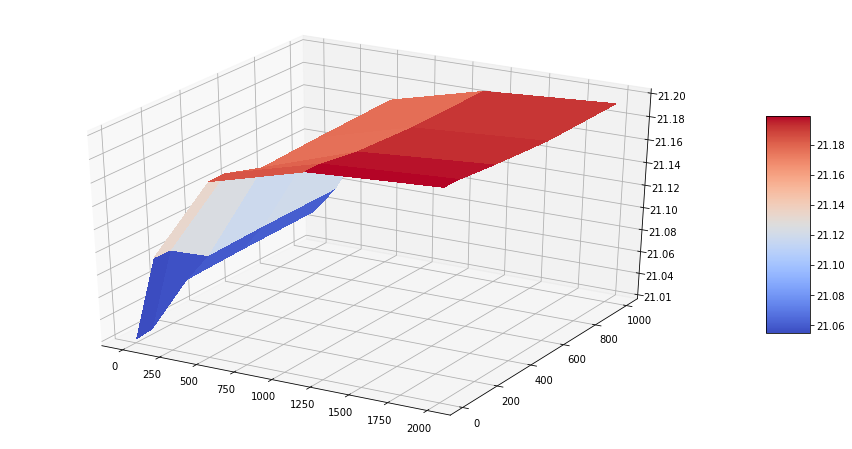

50
100


<Figure size 432x288 with 0 Axes>

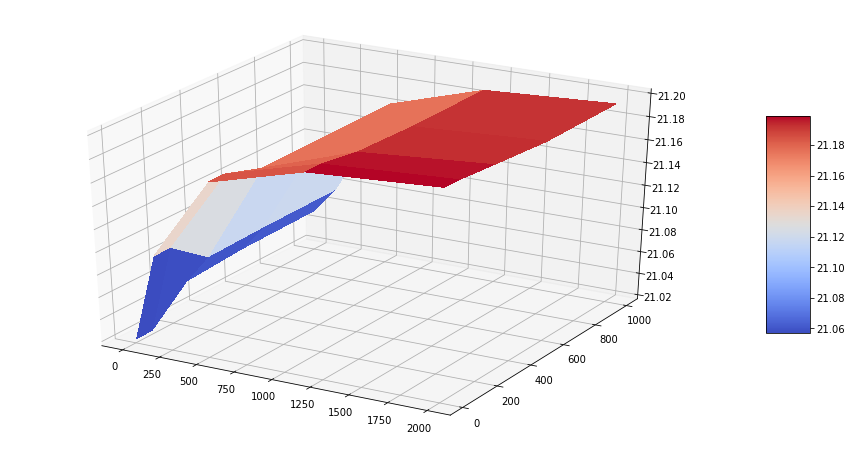

50
150


<Figure size 432x288 with 0 Axes>

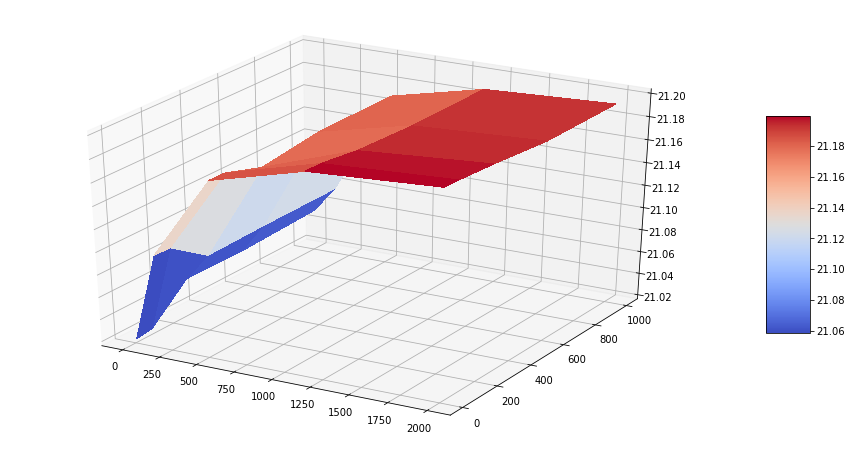

50
200


<Figure size 432x288 with 0 Axes>

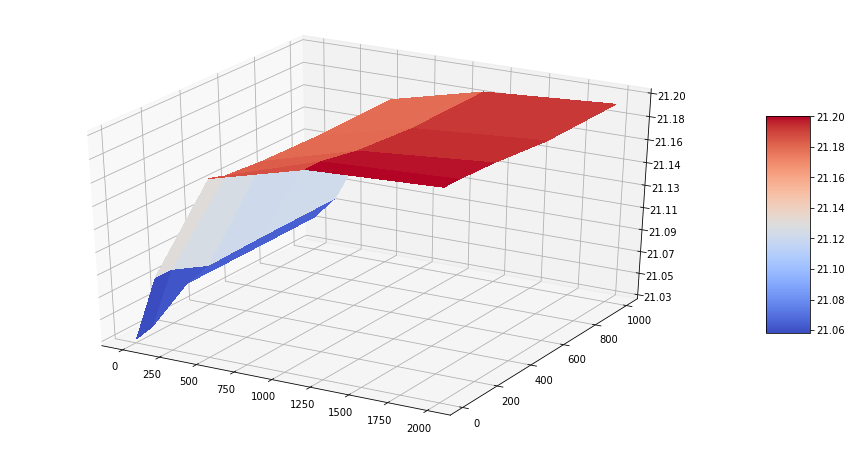

100
50


<Figure size 432x288 with 0 Axes>

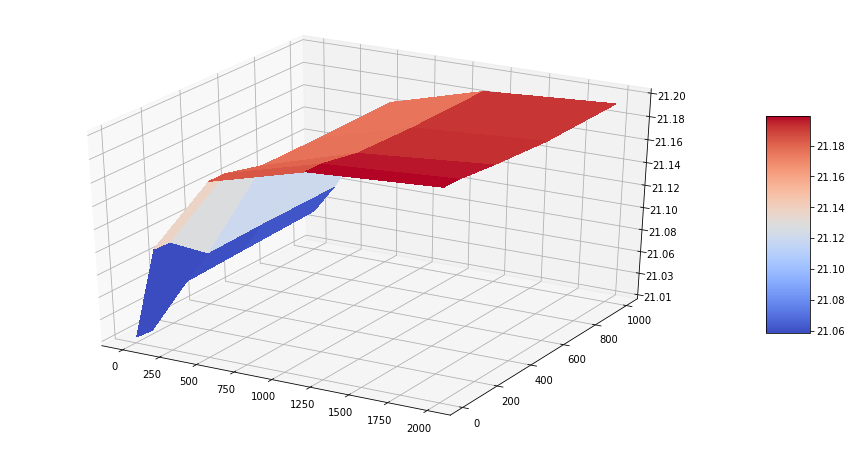

100
100


<Figure size 432x288 with 0 Axes>

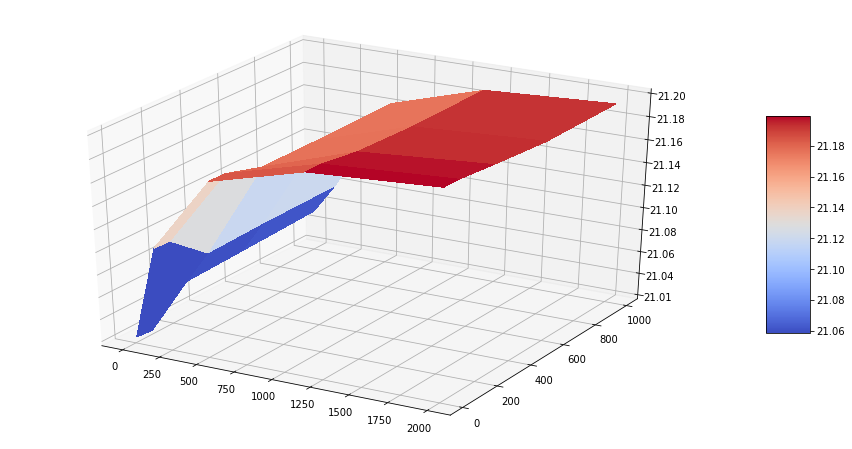

100
150


<Figure size 432x288 with 0 Axes>

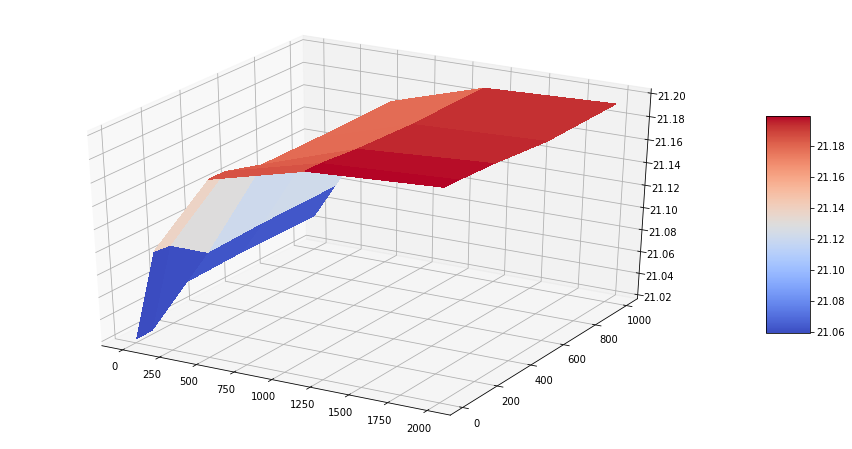

100
200


<Figure size 432x288 with 0 Axes>

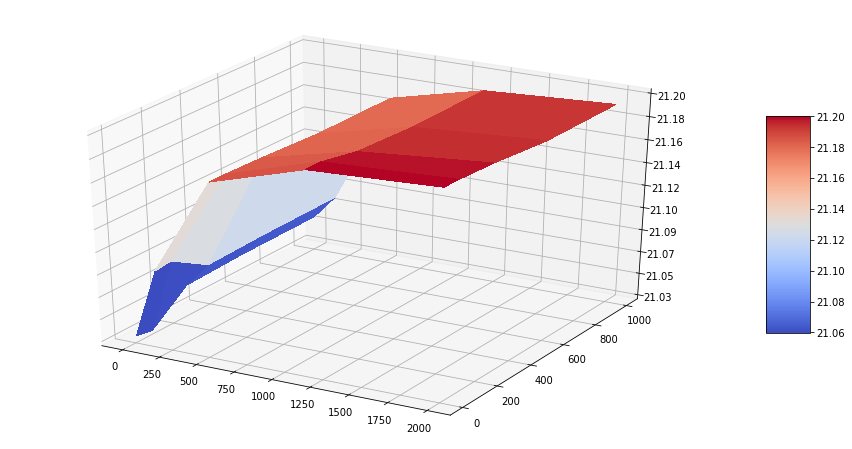

150
50


<Figure size 432x288 with 0 Axes>

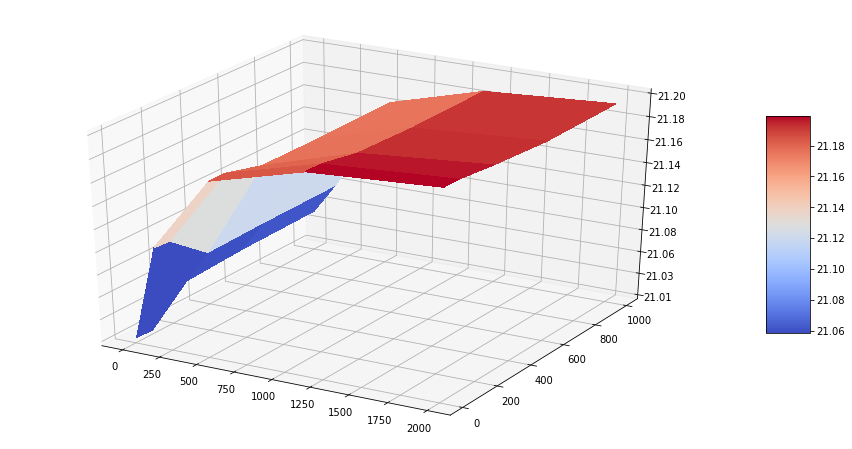

150
100


<Figure size 432x288 with 0 Axes>

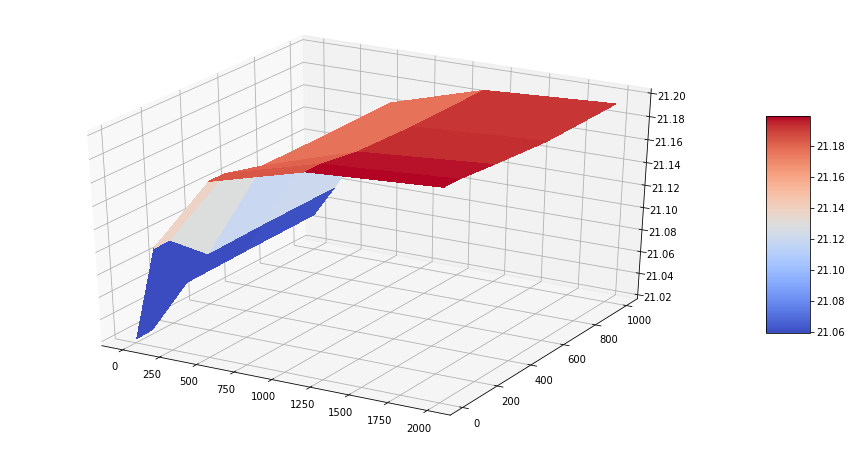

150
150


<Figure size 432x288 with 0 Axes>

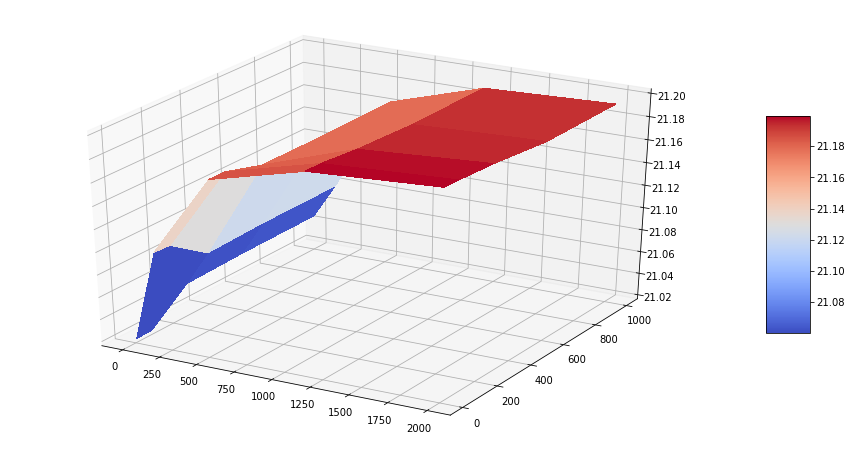

150
200


<Figure size 432x288 with 0 Axes>

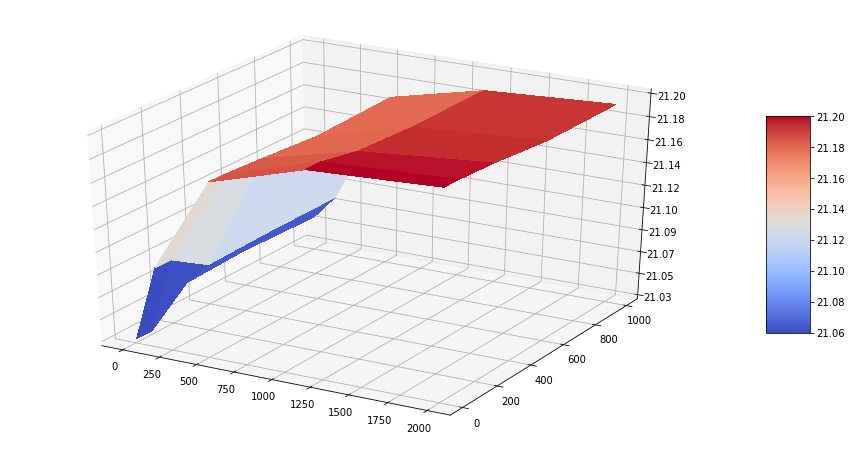

200
50


<Figure size 432x288 with 0 Axes>

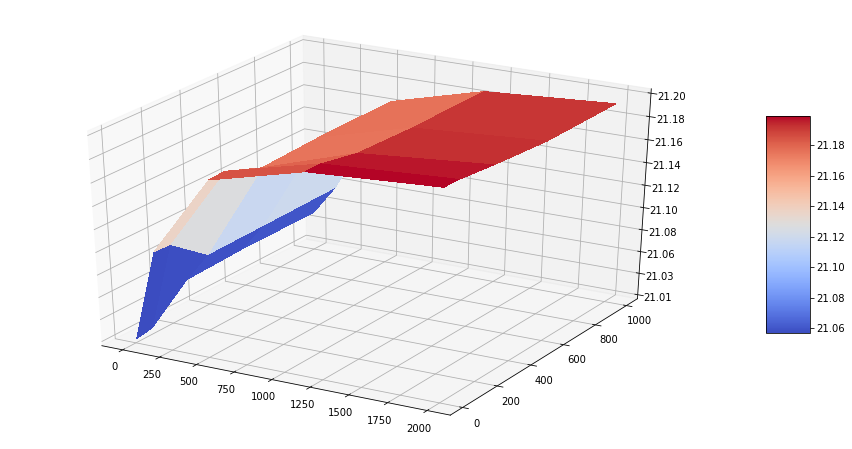

200
100


<Figure size 432x288 with 0 Axes>

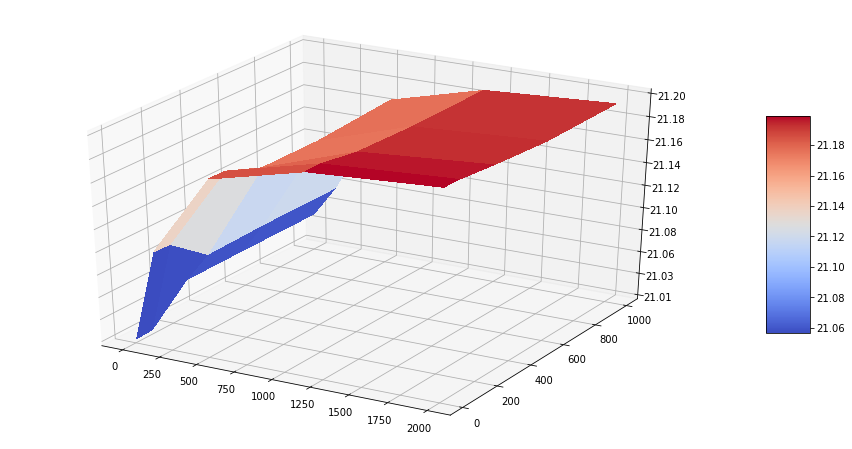

200
150


<Figure size 432x288 with 0 Axes>

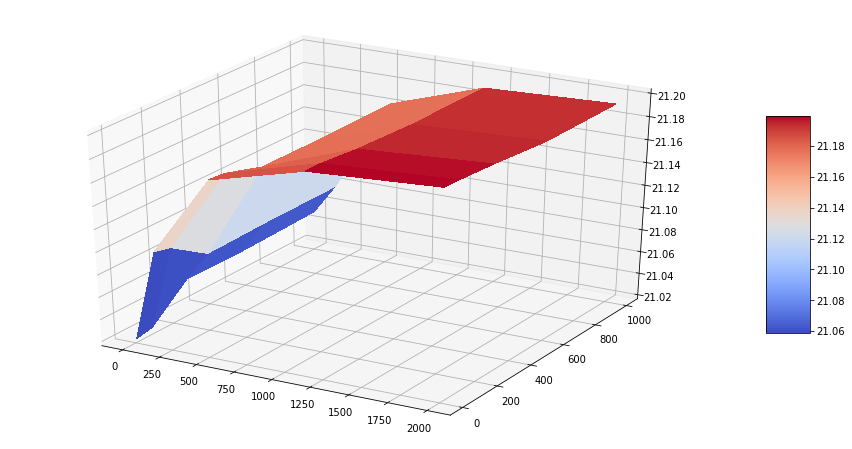

200
200


<Figure size 432x288 with 0 Axes>

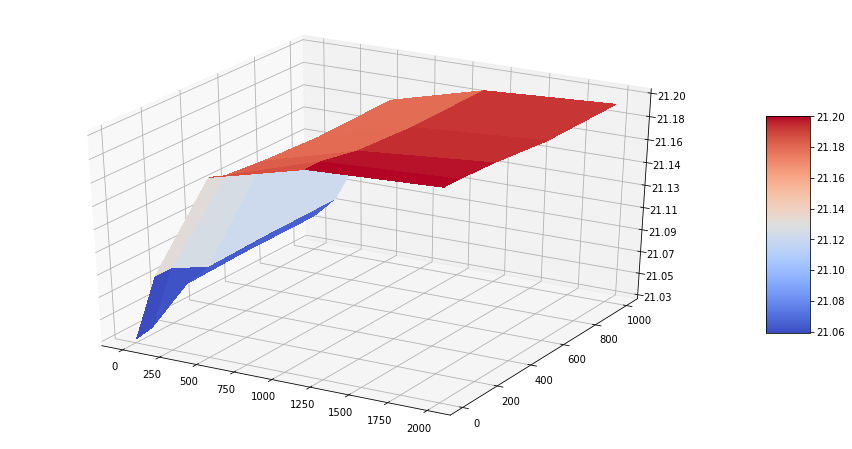

In [8]:
# Mortgage amount 
Ms = np.array([50, 100, 150, 200])
# Improvement amount 
gs = np.array([10, 20, 100, 200])
for i in range(len(Ms)):
    for j in range(len(gs)):
        print(Ms[i])
        print(Ms[j])
        plt.figure()  
        surfacePlot(xgrid[:,:,i,j,1,1,1,0], xgrid[:,:,i,j,1,1,1,1], Vgrid[:,:,i,j,1,1,1,t])
        plt.show()

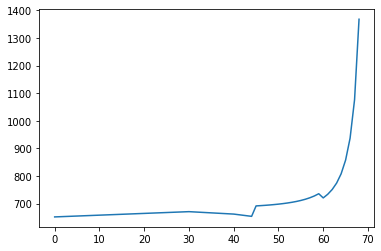

In [9]:
plt.plot(cgrid[4,3,2,2,1,1,1,:69])

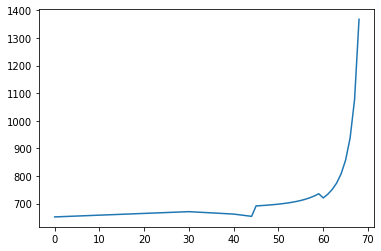

In [10]:
plt.plot(bgrid[4,3,2,2,1,1,1,:69])

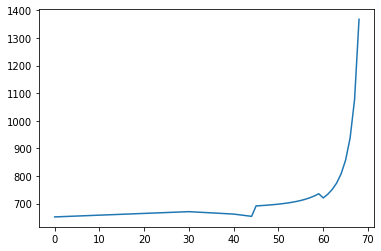

In [11]:
plt.plot(kgrid[4,3,2,2,1,1,1,:69])

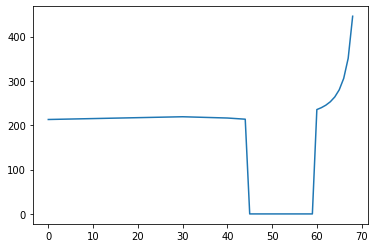

In [12]:
plt.plot(igrid[4,3,2,2,1,1,1,:69])

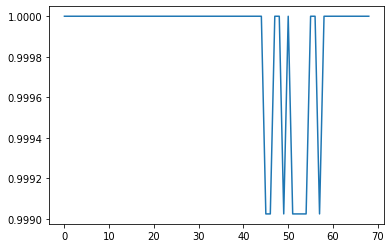

In [13]:
plt.plot(qgrid[4,3,2,2,1,1,1,:69])

In [14]:
# np.save("Vgrid", Vgrid)
# np.save("cgrid", cgrid)
# np.save("bgrid", bgrid)
# np.save("kgrid", kgrid)
# np.save("igrid", igrid)
# np.save("qgrid", qgrid)
# Vgrid = np.load("Vgrid.npy")